## ProjF5 - Final Model

Use this document as a template to provide the evaluation of your final model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [1]:
# Importing all the neccessary libraries
import librosa
import torch
import IPython.display as display
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import numpy as np
from os import listdir
import pandas as pd
import torchaudio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

In [2]:
#loading pre-trained model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

#function to convert the audio files into text transcriptions 
def speechToText(filename):
    audio, sampling_rate = librosa.load(filename,sr=16000)
    input_values = tokenizer(audio, return_tensors = 'pt').input_values
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim =-1)
    transcriptions = tokenizer.decode(predicted_ids[0])
    return transcriptions

#function that extracts metadata from audio files 
def audioMetadata(filename):
    metadata = torchaudio.info(filename)
    return metadata.sample_rate, metadata.num_frames


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/opt/homebrew/lib/python3.11/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:733: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification 

In [3]:
# Directory containing training audio files
train_files = listdir("Medical Speech, Transcription, and Intent/recordings/train")

# Create an empty DataFrame for training data
df_train = pd.DataFrame()

# Path prefix for training files
suffix_train = "Medical Speech, Transcription, and Intent/recordings/train/"

# Lists to store transcription, sample rate, and number of frames
transcriptions = []
sample_rates = []
num_of_frames = []

# Iterate through training files
for row in train_files:
    # Convert audio to text and append to transcriptions list
    transcriptions.append(speechToText(str(suffix_train + row)))
    
    # Extract sample rate and number of frames from audio metadata
    sample_rates.append(audioMetadata(str(suffix_train + row))[0])
    num_of_frames.append(audioMetadata(str(suffix_train + row))[1])

# Add columns to DataFrame
df_train["filename"] = train_files
df_train["transcriptions"] = transcriptions
df_train["sample_rate"] = sample_rates
df_train["num_frames"] = num_of_frames

# Save DataFrame to CSV file
df_train.to_csv("Medical Speech, Transcription, and Intent/train_data.csv")

# Display the first 5 rows of the DataFrame
df_train.head(5)

,filename,transcriptions,sample_rate,num_frames
0,1249120_30766630_68687326.wav,I HAD A PAY IN MY KNEE WHEN I WAS SWIMMING,44100,167936
1,1249120_43620482_83629897.wav,I CAN'T CARRY ANYTHING I HAVE A PAIN ON MY SHO...,48000,208896
2,1249120_43758322_46768180.wav,I HAVE THESE STRANGE GRASH ON MY ARM,48000,200704
3,1249120_43612961_52251557.wav,I HAVE A STRONG SHOULDER PAIN,44100,135168
4,1249120_41087148_36008493.wav,MY HAIR ALL THIS FALS OUTO AND I HAVE LOST IN ...,48000,327680


In [4]:
# Directory containing test audio files
test_files = listdir("Medical Speech, Transcription, and Intent/recordings/test")

# Create an empty DataFrame for test data
df_test = pd.DataFrame()

# Path prefix for test files
suffix_test = "Medical Speech, Transcription, and Intent/recordings/test/"

# Lists to store transcription, sample rate, and number of frames
transcriptions = []
sample_rates = []
num_of_frames = []

# Iterate through test files
for row in test_files:
    # Convert audio to text and append to transcriptions list
    transcriptions.append(speechToText(str(suffix_test + row)))
    
    # Extract sample rate and number of frames from audio metadata
    sample_rates.append(audioMetadata(str(suffix_test + row))[0])
    num_of_frames.append(audioMetadata(str(suffix_test + row))[1])

# Add columns to DataFrame
df_test["filename"] = test_files
df_test["transcriptions"] = transcriptions
df_test["sample_rate"] = sample_rates
df_test["num_frames"] = num_of_frames

# Save DataFrame to CSV file
df_test.to_csv("Medical Speech, Transcription, and Intent/test_data.csv")

# Display the first 5 rows of the DataFrame
df_test.head(5)

,filename,transcriptions,sample_rate,num_frames
0,1249120_44176037_58635902.wav,I WAS DIAGNOS WITH NEMONA I CAN'T BREATHE EASILY,48000,253952
1,1249120_44176037_96532055.wav,I FEEL MUSCLE PAIN EVERY TIME I MAKE AN EXTRA ...,48000,241664
2,1249120_44220382_41016711.wav,I HAVE A BACK PAIN SINCE I FELL ON THE FLOOR,44100,118784
3,1249120_44188922_16615356.wav,WHEN I TRIED TO BE WARM AND WEN MORE CLOSE I F...,48000,225280
4,1249120_44246595_60938320.wav,MY EAR HURTS ME BADLY,44100,110592


In [5]:
# Directory containing validation audio files
validation_files = listdir("Medical Speech, Transcription, and Intent/recordings/validate")

# Create an empty DataFrame for validation data
df_validation = pd.DataFrame()

# Path prefix for validation files
suffix_validation = "Medical Speech, Transcription, and Intent/recordings/validate/"

# Lists to store transcription, sample rate, and number of frames
transcriptions = []
sample_rates = []
num_of_frames = []

# Iterate through validation files
for row in validation_files:
    # Convert audio to text and append to transcriptions list
    transcriptions.append(speechToText(str(suffix_validation + row)))
    
    # Extract sample rate and number of frames from audio metadata
    sample_rates.append(audioMetadata(str(suffix_validation + row))[0])
    num_of_frames.append(audioMetadata(str(suffix_validation + row))[1])

# Add columns to DataFrame
df_validation["filename"] = validation_files
df_validation["transcriptions"] = transcriptions
df_validation["sample_rate"] = sample_rates
df_validation["num_frames"] = num_of_frames

# Save DataFrame to CSV file
df_validation.to_csv("Medical Speech, Transcription, and Intent/validate_data.csv")

# Display the first 5 rows of the DataFrame
df_validation.head(5)

,filename,transcriptions,sample_rate,num_frames
0,1249120_44263136_59289865.wav,WHEN I'M TOO HIGH I START TO FEEL DIZZY,44100,180224
1,1249120_44273314_47748885.wav,MY BODY FEELS WEAK ALTHOUGH I EAT A LOT WHY,48000,204800
2,1249120_44273314_40698632.wav,I FEEL A GREAT AMOUNT OF PRESSURE ON THE SIDES...,48000,184320
3,1249120_44323331_82659146.wav,WHO AN I WARK IT HARD TO BIT,44100,225280
4,1249120_44273314_84611968.wav,MINACE HAS BEEN SORE SINCE THE ACCIDENT,48000,151552


In [6]:
# Reading the csv that contains the category labels with filenames
df_labels = pd.read_csv("Medical Speech, Transcription, and Intent/labels.csv")

In [7]:
# Merge test data with labels and select relevant columns
df_test = pd.merge(df_test, df_labels, left_on="filename", right_on="file_name", how="inner")[["filename", "transcriptions", "sample_rate", "num_frames", "prompt"]]

# Merge train data with labels and select relevant columns
df_train = pd.merge(df_train, df_labels, left_on="filename", right_on="file_name", how="inner")[["filename", "transcriptions", "sample_rate", "num_frames", "prompt"]]

# Merge validation data with labels and select relevant columns
df_validate = pd.merge(df_validation, df_labels, left_on="filename", right_on="file_name", how="inner")[["filename", "transcriptions", "sample_rate", "num_frames", "prompt"]]

# Concatenate all dataframes to adjust the test, train and validate split
df_model = pd.concat([df_test, df_train, df_validate])

### 2. Prepare your Final Model

Here you can have your code to either train (e.g., if you are building it from scratch) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

In [8]:
# Split data into features (transcriptions) and labels (prompt)
X = df_model['transcriptions'].values
y = pd.get_dummies(df_model['prompt']).values  # Assuming one-hot encoding for class labels

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained Sentence Transformers model
sentence_transformer_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Encode text inputs using Sentence Transformers model
X_train_encoded = sentence_transformer_model.encode(X_train, convert_to_tensor=True)
X_train_encoded = X_train_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_val_encoded = sentence_transformer_model.encode(X_val, convert_to_tensor=True)
X_val_encoded = X_val_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_test_encoded = sentence_transformer_model.encode(X_test, convert_to_tensor=True)
X_test_encoded = X_test_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

# Define input shape
input_text = Input(shape=(X_train_encoded.shape[1],), dtype=tf.float32)

# Dense layer for classification
dense = Dense(1024, activation='relu')(input_text)
output = Dense(y.shape[1], activation='softmax')(dense)  # Number of classes based on one-hot encoding

# Define model
model = Model(inputs=input_text, outputs=output)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train only the added Dense layers
history = model.fit(X_train_encoded, y_train, batch_size=32, epochs=5, validation_data=(X_val_encoded, y_val))

# Unlock the Sentence Transformers model for further fine-tuning
for layer in sentence_transformer_model.parameters():
    layer.requires_grad = True
# Compile the model again to apply changes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the entire model
history_finetune = model.fit(X_train_encoded, y_train, batch_size=32, epochs=50, validation_data=(X_val_encoded, y_val))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_encoded, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3720 - loss: 2.2832 - val_accuracy: 0.6381 - val_loss: 1.3504
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6566 - loss: 1.2403 - val_accuracy: 0.6667 - val_loss: 1.2601
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7382 - loss: 0.9404 - val_accuracy: 0.6892 - val_loss: 1.1552
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8027 - loss: 0.7384 - val_accuracy: 0.7087 - val_loss: 1.1295
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8380 - loss: 0.5851 - val_accuracy: 0.6982 - val_loss: 1.1970
Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8463 - loss: 0.5338 - val_accuracy: 0.6967 - val_loss: 1.2515
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9114 - loss: 0.3482 - val_accuracy: 0.7042 - val_loss: 1.2154
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9294 - loss: 0.2842 - val_accuracy: 0.6997 

### 3. Model Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

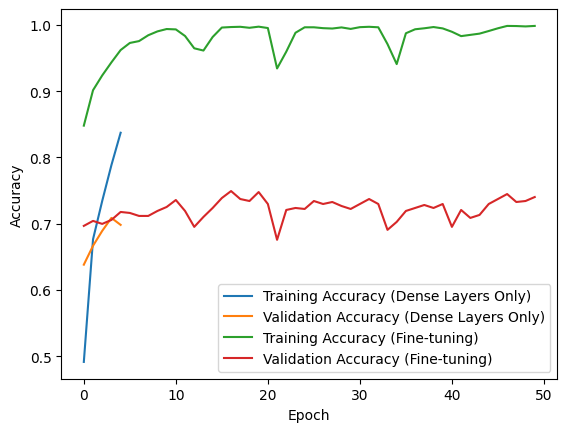

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


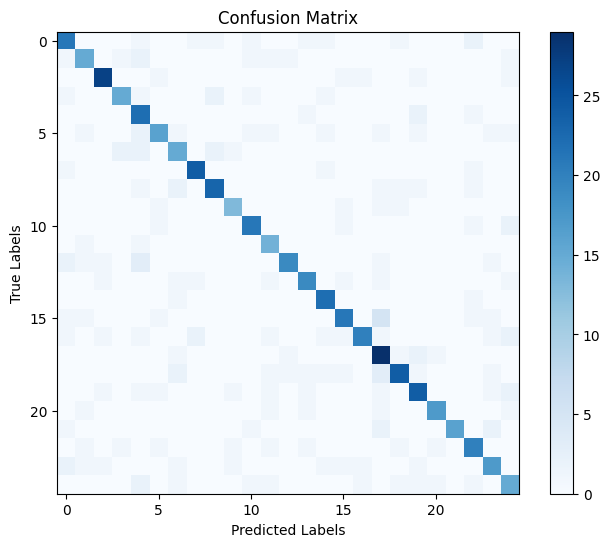

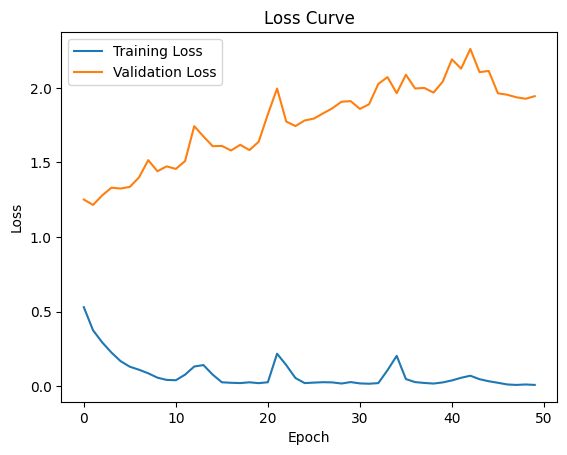

In [14]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy (Dense Layers Only)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Dense Layers Only)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test_encoded), axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot Loss Curve
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
